# CNN모델

In [1]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
from sklearn.metrics import accuracy_score

In [3]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [4]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [5]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [6]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [7]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [8]:
# CNN 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
print(X_train.shape)

(8010, 29)


In [10]:
X_train

array([[232, 355, 361, ...,   0,   0,   0],
       [114, 185, 888, ...,   0,   0,   0],
       [353, 325,  11, ...,   0,   0,   0],
       ...,
       [ 28,  37,  36, ...,   0,   0,   0],
       [143, 543,  77, ...,   0,   0,   0],
       [ 79, 121, 217, ...,   0,   0,   0]])

In [11]:
y_train

array([35, 15, 14, ..., 37, 58, 33])

In [12]:
#모델 훈현
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
251/251 [==============================] - 4s 13ms/step - loss: 2.8208 - accuracy: 0.3659 - val_loss: 1.4425 - val_accuracy: 0.6710
Epoch 2/10
251/251 [==============================] - 3s 12ms/step - loss: 0.6949 - accuracy: 0.8537 - val_loss: 0.5168 - val_accuracy: 0.8922
Epoch 3/10
251/251 [==============================] - 3s 12ms/step - loss: 0.2015 - accuracy: 0.9598 - val_loss: 0.3844 - val_accuracy: 0.9066
Epoch 4/10
251/251 [==============================] - 3s 12ms/step - loss: 0.0709 - accuracy: 0.9891 - val_loss: 0.3453 - val_accuracy: 0.9181
Epoch 5/10
251/251 [==============================] - 3s 12ms/step - loss: 0.0290 - accuracy: 0.9960 - val_loss: 0.3375 - val_accuracy: 0.9246
Epoch 6/10
251/251 [==============================] - 3s 12ms/step - loss: 0.0168 - accuracy: 0.9981 - val_loss: 0.3206 - val_accuracy: 0.9261
Epoch 7/10
251/251 [==============================] - 3s 12ms/step - loss: 0.0095 - accuracy: 0.9990 - val_loss: 0.3322 - val_accuracy: 0.9236

In [13]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
CNN_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", CNN_accuracy)

Accuracy: 0.9211183225162256


In [20]:
# 새로운 입력 데이터 예측
new_text = input("새로운 문장을 입력하세요: ")
preprocessed_new_text = preprocess_text(new_text)
sequence = tokenizer.texts_to_sequences([preprocessed_new_text])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
prediction = model.predict(padded_sequence)
predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]

# 예측 결과 출력
print(f"입력 문장: {new_text}")
print(f"예측된 레이블: {predicted_label}")

새로운 문장을 입력하세요: 서울아산병원 AMIST/울산의대 신약개발 사이버 썸머스쿨” 온라인 강의 개최
1/1 [==============================] - 0s 19ms/step
입력 문장: 서울아산병원 AMIST/울산의대 신약개발 사이버 썸머스쿨” 온라인 강의 개최
예측된 레이블: 특강


# MLP모델

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [163]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [256]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [257]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [258]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y[:len(padded_X)], test_size=0.2, random_state=42)

In [259]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(max_sequence_length,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [260]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [261]:
X_train

array([[232, 355, 361, ...,   0,   0,   0],
       [114, 185, 888, ...,   0,   0,   0],
       [353, 325,  11, ...,   0,   0,   0],
       ...,
       [ 28,  37,  36, ...,   0,   0,   0],
       [143, 543,  77, ...,   0,   0,   0],
       [ 79, 121, 217, ...,   0,   0,   0]])

In [262]:
y_train

array([35, 15, 14, ..., 37, 58, 33])

In [263]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
251/251 [==============================] - 0s 1ms/step - loss: 40.9803 - accuracy: 0.0458 - val_loss: 4.9570 - val_accuracy: 0.0854
Epoch 2/100
251/251 [==============================] - 0s 796us/step - loss: 4.3616 - accuracy: 0.0839 - val_loss: 4.2588 - val_accuracy: 0.0854
Epoch 3/100
251/251 [==============================] - 0s 818us/step - loss: 4.0708 - accuracy: 0.0846 - val_loss: 4.0762 - val_accuracy: 0.0869
Epoch 4/100
251/251 [==============================] - 0s 834us/step - loss: 3.9662 - accuracy: 0.0850 - val_loss: 3.9847 - val_accuracy: 0.0869
Epoch 5/100
251/251 [==============================] - 0s 823us/step - loss: 3.9110 - accuracy: 0.0851 - val_loss: 3.9196 - val_accuracy: 0.0874
Epoch 6/100
251/251 [==============================] - 0s 769us/step - loss: 3.8765 - accuracy: 0.0854 - val_loss: 3.8846 - val_accuracy: 0.0874
Epoch 7/100
251/251 [==============================] - 0s 773us/step - loss: 3.8558 - accuracy: 0.0853 - val_loss: 3.8622 - val_acc

In [264]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
MLP_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", MLP_accuracy)

Accuracy: 0.08736894658012981


# SVM

In [192]:
from sklearn.svm import SVC

In [193]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

In [194]:
#데이터 전처리 테스트가 벡터로 변환
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['title'])
y = df['class']

In [195]:
#훈련 데이터 분리 train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [196]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [199]:
y_pred = model.predict(X_test)
SVM_accuracy = accuracy_score(y_test, y_pred)
print("정확도:", SVM_accuracy)

정확도: 0.7903145282076884


# LSTM

In [180]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from konlpy.tag import Okt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM

In [181]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [182]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [183]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [184]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [185]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [186]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [187]:
# LSTM 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [188]:
# 모델 훈련
model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/50
251/251 [==============================] - 4s 11ms/step - loss: 3.7911 - accuracy: 0.0793 - val_loss: 3.5480 - val_accuracy: 0.1048
Epoch 2/50
251/251 [==============================] - 3s 10ms/step - loss: 3.3451 - accuracy: 0.1146 - val_loss: 3.0594 - val_accuracy: 0.1578
Epoch 3/50
251/251 [==============================] - 2s 10ms/step - loss: 2.7736 - accuracy: 0.2047 - val_loss: 2.6753 - val_accuracy: 0.2267
Epoch 4/50
251/251 [==============================] - 2s 10ms/step - loss: 2.3126 - accuracy: 0.3079 - val_loss: 2.2554 - val_accuracy: 0.3615
Epoch 5/50
251/251 [==============================] - 2s 10ms/step - loss: 1.7378 - accuracy: 0.4866 - val_loss: 1.8202 - val_accuracy: 0.5162
Epoch 6/50
251/251 [==============================] - 3s 10ms/step - loss: 1.2747 - accuracy: 0.6213 - val_loss: 1.6335 - val_accuracy: 0.5736
Epoch 7/50
251/251 [==============================] - 3s 10ms/step - loss: 0.9366 - accuracy: 0.7199 - val_loss: 1.4283 - val_accuracy: 0.6555

In [189]:
y_prob = model.predict(X_test, verbose=0) 
y_pred = y_prob.argmax(axis=-1)
LSTM_accuracy = np.sum(y_pred.flatten() == y_test) / len(y_test)
print("Accuracy:", LSTM_accuracy)

Accuracy: 0.8607089365951074


# GRU

In [219]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [202]:
# CSV 파일 읽기
df = pd.read_csv("./라벨링완료된공지사항(수정본).csv") 

notice_names = df['title'].tolist()

# 전처리 함수 정의
def preprocess_text(text):
    # 특수문자 제거
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", "", text)

    # 숫자 정보 제거
    text = re.sub(r'\d+', '', text)

    # 형태소 분석
    tagger = Okt()
    words = tagger.morphs(text)

    # 불용어 제거
    stop_words = ['필독', '학기', '학년', '도', '년', '제', '회', '월', '학부', '일', '차', '년도', '안내']  # 불용어 리스트
    words = [word for word in words if word not in stop_words]

    # 분석된 형태소들을 공백으로 결합하여 문장으로 반환
    text = ' '.join(words)

    return text


preprocessed_notice_names = [preprocess_text(notice_name) for notice_name in notice_names]

In [221]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_notice_names)

tfidf_model = TfidfVectorizer().fit(preprocessed_notice_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['class'])

In [226]:
# 토크나이저 생성
tokenizer = Tokenizer()

# 토크나이저가 데이터를 학습
tokenizer.fit_on_texts(preprocessed_notice_names)

# 데이터를 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(preprocessed_notice_names)

# 가장 긴 문장의 길이를 확인
max_sequence_length = max(len(s) for s in sequences)
print('가장 긴 문장의 길이:', max_sequence_length)

# 어휘 사전의 크기를 확인 (+1을 하는 이유는 0인덱스를 고려하기 때문입니다.)
vocab_size = len(tokenizer.word_index) + 1
print('어휘 사전의 크기:', vocab_size)

# 모든 문장을 가장 긴 문장의 길이로 패딩 처리
padded_X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

가장 긴 문장의 길이: 29
어휘 사전의 크기: 6097


In [227]:
# 훈련 데이터 분리: train 데이터 80%, test 데이터 20%
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

In [228]:
# 타겟 변수 다중 클래스 원-핫 인코딩
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [236]:
# GUR모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_sequence_length))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='softmax'))

# 출력 뉴런의 개수와 활성화 함수를 클래스 개수에 따라 조정
num_classes = len(set(y))  # 클래스 개수 계산
if num_classes == 2:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [255]:
# 모델 훈련
model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, validation_data=(X_test, y_test_encoded))

#정확도 측정
loss, GUR_accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", GUR_accuracy)

Epoch 1/200
251/251 [==============================] - 6s 24ms/step - loss: 1.0689 - accuracy: 0.6426 - val_loss: 1.9011 - val_accuracy: 0.5657
Epoch 2/200
251/251 [==============================] - 6s 23ms/step - loss: 1.0553 - accuracy: 0.6429 - val_loss: 1.8917 - val_accuracy: 0.5652
Epoch 3/200
251/251 [==============================] - 6s 23ms/step - loss: 1.0592 - accuracy: 0.6412 - val_loss: 1.8947 - val_accuracy: 0.5796
Epoch 4/200
251/251 [==============================] - 6s 24ms/step - loss: 1.0537 - accuracy: 0.6508 - val_loss: 1.9027 - val_accuracy: 0.5761
Epoch 5/200
251/251 [==============================] - 6s 23ms/step - loss: 1.0456 - accuracy: 0.6499 - val_loss: 1.8858 - val_accuracy: 0.5806
Epoch 6/200
251/251 [==============================] - 6s 23ms/step - loss: 1.0348 - accuracy: 0.6512 - val_loss: 1.8520 - val_accuracy: 0.5831
Epoch 7/200
251/251 [==============================] - 6s 23ms/step - loss: 1.0191 - accuracy: 0.6654 - val_loss: 1.8770 - val_accuracy:

# 성능 비교 시각화

In [238]:
import matplotlib.pyplot as plt

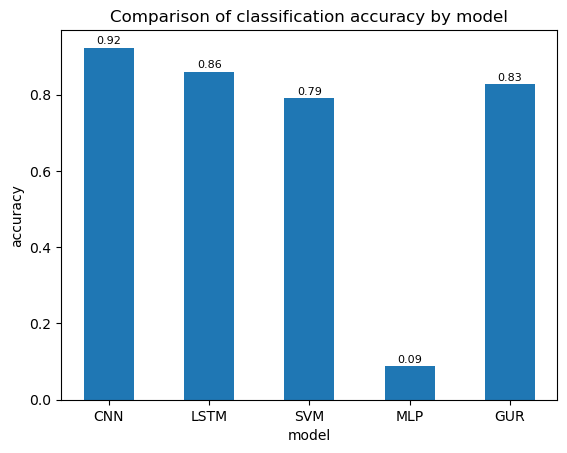

In [265]:
#그래프로 성능 비교 

x = ('CNN', 'LSTM','SVM','MLP','GUR')
y = [CNN_accuracy, LSTM_accuracy,SVM_accuracy,MLP_accuracy,GUR_accuracy]
plt.xlabel("model")
plt.ylabel("accuracy")
width = 0.5 
plt.bar(x, y,width)  # 데이터 가로 나온 함수 barh
plt.title('Comparison of classification accuracy by model')
for a,b,i in zip(x,y,range(len(x))): # zip 函数
    plt.text(a,b+0.01,"%.2f"%y[i],ha='center',fontsize=8) # plt.text 함수


plt.show()
